### 필요 패키지 import

In [70]:

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import SGD
import torch.nn.functional as F
from model import AclNet
from mydataset import SoundDataset


### Train & Test Dataset

In [71]:
train_data_path = './datasets/train/'
test_data_path = './datasets/test/'

train_dataset = SoundDataset(train_data_path)
test_dataset = SoundDataset(test_data_path)


### Test 코드

In [72]:
def test(model, test_dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (data, label) in enumerate(test_dataloader):
            data, label = data.to(device), label.to(device)

            output = model(data)

            loss = criterion(output, label)
            test_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
            
    avg_loss = test_loss / len(test_dataloader)
    print(f"Test Loss : {avg_loss:.4f}")
    
    return avg_loss

### Model 학습

cuda
Epoch [1/200][10/20] - Loss: 2.0356
Epoch [1/200][20/20] - Loss: 1.8229
Test Loss : 2.3328
Epoch [1/200] - Train Loss: 2.0401
Epoch [2/200][10/20] - Loss: 1.7276
Epoch [2/200][20/20] - Loss: 1.7705
Test Loss : 2.2909
Epoch [2/200] - Train Loss: 1.7821
Epoch [3/200][10/20] - Loss: 1.7443
Epoch [3/200][20/20] - Loss: 1.8351
Test Loss : 1.7630
Epoch [3/200] - Train Loss: 1.6805
Epoch [4/200][10/20] - Loss: 1.5205
Epoch [4/200][20/20] - Loss: 1.6420
Test Loss : 1.5464
Epoch [4/200] - Train Loss: 1.5750
Epoch [5/200][10/20] - Loss: 1.8074
Epoch [5/200][20/20] - Loss: 1.5890
Test Loss : 1.6324
Epoch [5/200] - Train Loss: 1.5313
Epoch [6/200][10/20] - Loss: 1.4687
Epoch [6/200][20/20] - Loss: 1.4143
Test Loss : 1.3934
Epoch [6/200] - Train Loss: 1.4085
Epoch [7/200][10/20] - Loss: 1.5478
Epoch [7/200][20/20] - Loss: 1.4347
Test Loss : 1.3423
Epoch [7/200] - Train Loss: 1.3466
Epoch [8/200][10/20] - Loss: 1.5037
Epoch [8/200][20/20] - Loss: 1.0982
Test Loss : 1.2855
Epoch [8/200] - Train 

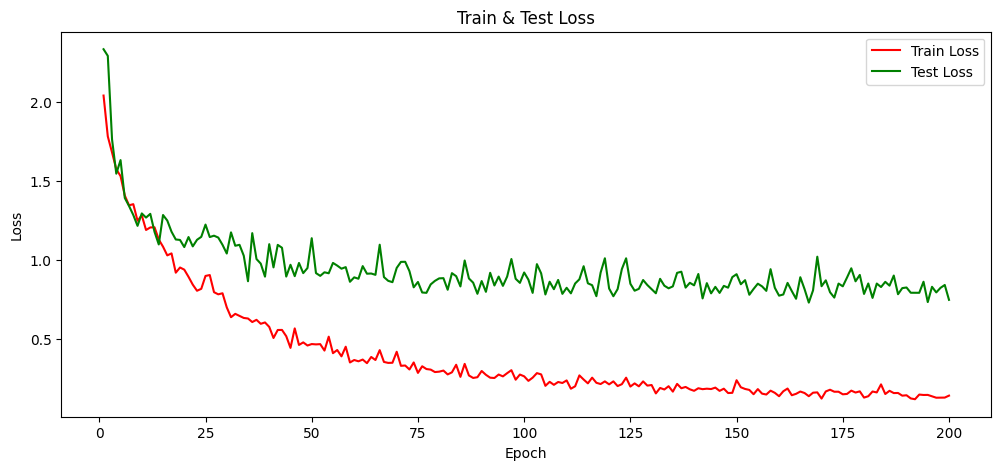

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = AclNet(input_channel=1, num_classes=10)
model = model.to(device)

# optim = Adam(model.parameters(), lr=0.001)
optim = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=2e-4)
criterion = nn.CrossEntropyLoss()

num_epoch = 200
train_losses = []
test_losses = []

for epoch in range(num_epoch):
    model.train()
    train_loss = .0

    for i, (data, label) in enumerate(train_data_loader):
        data, label = data.to(device), label.to(device)
        optim.zero_grad()

        output = model(data)

        loss = criterion(output, label)
        loss.backward()
        optim.step()

        train_loss += loss.item()
        
        if ((i + 1) % 10) == 0:
            print(f"Epoch [{epoch+1}/{num_epoch}][{i+1}/{len(train_data_loader)}] - Loss: {loss.item():.4f}")

    avg_train_loss = train_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    avg_test_loss = test(model, test_data_loader, criterion, device)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epoch}] - Train Loss: {avg_train_loss:.4f}")
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), './ckpts/{}_weight.pt'.format(epoch+1))

torch.save(model.state_dict(), './ckpts/last_weight.pt')

plt.figure(figsize=(12, 5))

plt.plot(range(1, num_epoch+1), train_losses, label='Train Loss', color='r')
plt.plot(range(1, num_epoch+1), test_losses, label='Test Loss', color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()

plt.savefig('./result_fig.png')


### 학습된 모델 불러오기

In [73]:
val_model = AclNet(1, 10)
val_model.load_state_dict(torch.load('./ckpts/last_weight.pt'))
val_model.eval()

val_model = val_model.to(device)

### 정확도 측정

In [ ]:
correct = 0
total = 0

all_scores = []
all_preds = []
all_labels = []

with torch.no_grad():
    for data, label in test_data_loader:
        data, label = data.to(device), label.to(device)

        output = val_model(data)

        prob = F.softmax(output, dim=1)
        predict_score, predict_label = torch.max(prob, 1)

        correct += (predict_label == label).sum().item()
        total += label.size(0) 

        all_scores.extend(predict_score.cpu().numpy())      # 예측 확률
        all_preds.extend(predict_label.cpu().numpy())       # 예측 라벨
        all_labels.extend(label.cpu().numpy())              # 실제 라벨

accuracy = correct / total  * 100

print(f"Test dataset num : {total}")
print(f"Accuracy : {accuracy}%")
    

Test dataset num : 320
Accuracy : 98.75%


### 시각화 (산점도)

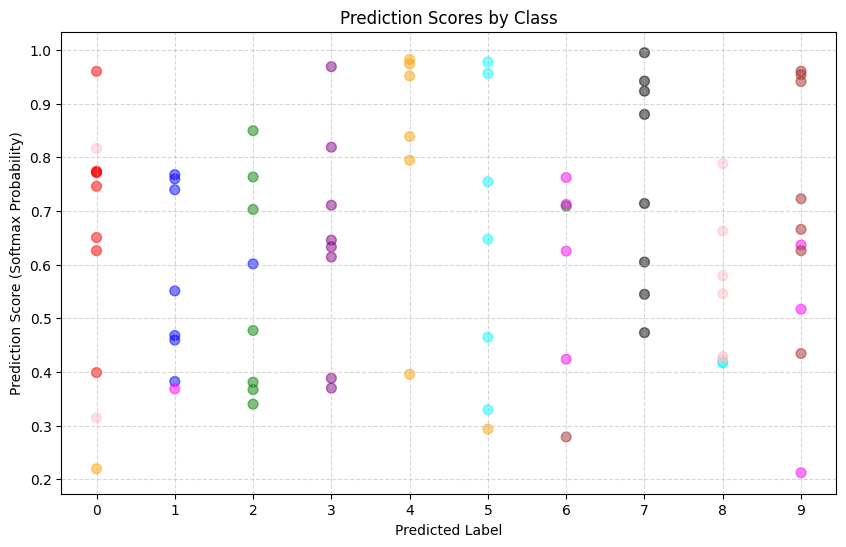

In [67]:
colors = np.array([
    'red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'black', 'pink', 'brown'
])

plt.figure(figsize=(10, 6))

# 산점도 그래프 그리기
scatter = plt.scatter(all_preds, all_scores, c=colors[all_labels], s=50, alpha=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("Prediction Score (Softmax Probability)")
plt.title("Prediction Scores by Class")

# 그리드 추가
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(np.arange(10))
plt.show()

### 시각화 (Confusion Matrix)

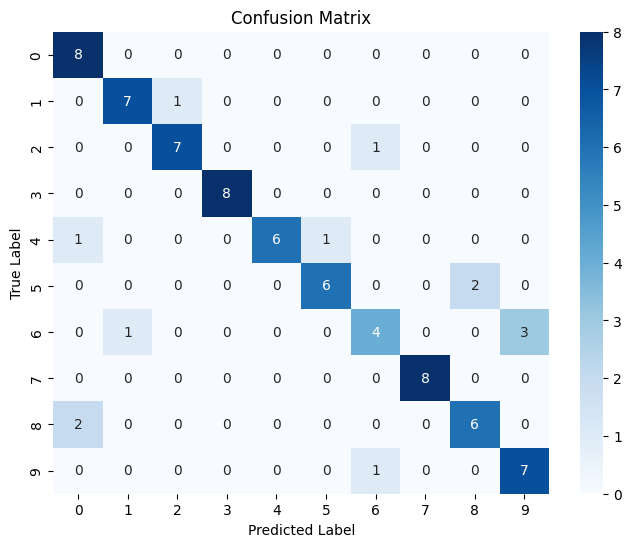

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()